In [80]:

import os
import numpy as np
import pandas as pd
import math 
import io
import requests
import itertools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [81]:


ratings = pd.read_csv("../input/ratings.csv")

movies = pd.read_csv('../input/movies.csv')
df_r = ratings.copy()
df_m = movies.copy()
ratings.head()



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [82]:
ratings.drop(['timestamp'], axis=1, inplace=True)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [83]:

df_combined = pd.merge(ratings, movies, on = 'movieId')
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [84]:
#Dictionary to store unique genres
genres = {} 

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [85]:
genres['None'] = genres.pop('(no genres listed)')

In [86]:
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)



,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


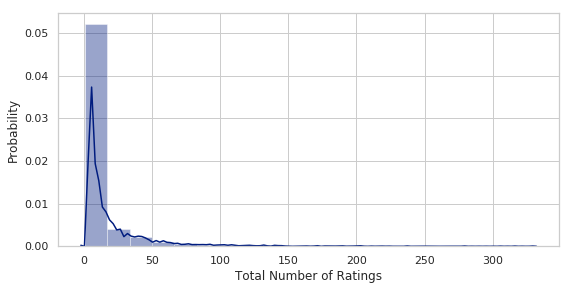

In [87]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

In [88]:


df_n_ratings.sort_values('mean ratings', ascending=False).head(10)


,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


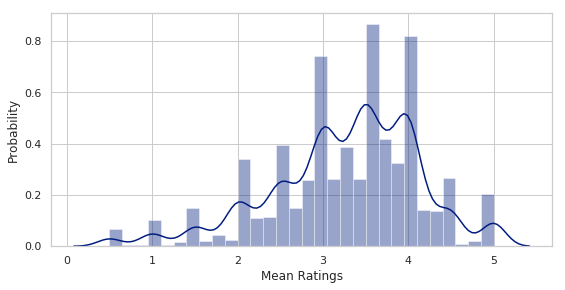

In [89]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

In [90]:
#Splitting Datasets
X = ratings.iloc[:,:2]
Y = ratings.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

In [91]:
n_latent_factors = 50
batch_size = 128
epochs = 20
# no of users and movies
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique()) 

In [92]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

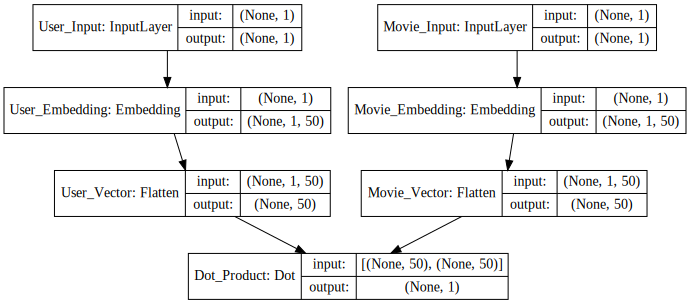

In [93]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [94]:
optimizer = Adam(lr = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer, metrics = ['accuracy'])


In [95]:
history = model.fit(x=[x_train["userId"], x_train["movieId"]], y=y_train, batch_size= batch_size, epochs=epochs, verbose= 2, validation_data=([x_test["userId"], x_test["movieId"]], y_test))


Train on 80668 samples, validate on 20168 samples
Epoch 1/20
 - 2s - loss: 13.3424 - acc: 0.0000e+00 - val_loss: 13.0289 - val_acc: 0.0000e+00
Epoch 2/20
 - 2s - loss: 11.2419 - acc: 0.0069 - val_loss: 8.2240 - val_acc: 0.0297
Epoch 3/20
 - 2s - loss: 6.3602 - acc: 0.0816 - val_loss: 5.2590 - val_acc: 0.1228
Epoch 4/20
 - 2s - loss: 4.7920 - acc: 0.1528 - val_loss: 4.5383 - val_acc: 0.1726
Epoch 5/20
 - 2s - loss: 4.2797 - acc: 0.1931 - val_loss: 4.2147 - val_acc: 0.2026
Epoch 6/20
 - 3s - loss: 4.0300 - acc: 0.2190 - val_loss: 4.0417 - val_acc: 0.2195
Epoch 7/20
 - 2s - loss: 3.8879 - acc: 0.2365 - val_loss: 3.9399 - val_acc: 0.2305
Epoch 8/20
 - 2s - loss: 3.7990 - acc: 0.2475 - val_loss: 3.8783 - val_acc: 0.2386
Epoch 9/20
 - 2s - loss: 3.7402 - acc: 0.2553 - val_loss: 3.8367 - val_acc: 0.2464
Epoch 10/20
 - 2s - loss: 3.6985 - acc: 0.2609 - val_loss: 3.8093 - val_acc: 0.2487
Epoch 11/20
 - 2s - loss: 3.6666 - acc: 0.2657 - val_loss: 3.7906 - val_acc: 0.2507
Epoch 12/20
 - 2s - loss

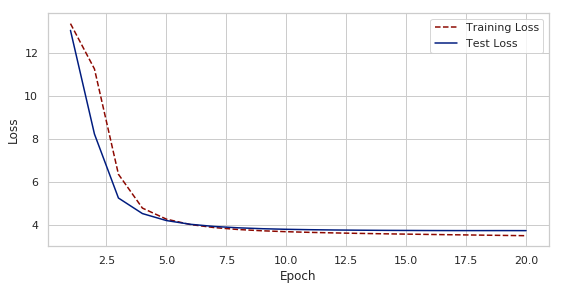

In [96]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)


plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [97]:


score = model.evaluate([x_test['userId'], x_test['movieId']], y_test)

print('RMSE: {:.4f}'.format(np.sqrt(score[0])))
print('Accuracy of Model: ',score[1] )



20168/20168 [==============================] - 1s 39us/step
RMSE: 1.9358
Accuracy of Model:  0.2563962713209044


In [98]:
df_comb = df_combined['movieId'].to_numpy()
df_movie_id = np.unique(df_comb)

#İnput User id [0-610]: 610 kullanıncıdan istenilen kullanıcı için tüm filmler arasında en çok beğenebileceği film tahmin edilmiştir.
input_user_id = 200
prediction_arr = []

pred_movie_frame = []

movie_id_arr = []


for i in range(len(df_movie_id)):
    input_movie_id = df_movie_id[i]
    data = {'userId':[input_user_id],'movieId':[input_movie_id]}
    input_user_data = pd.DataFrame(data)
    prediction = model.predict([input_user_data['userId'], input_user_data['movieId']])
    pred_df = pd.DataFrame(prediction[0],columns = ['prediction'])
    pred_val = prediction[0].astype(float)
    input_movie_id_df = pd.DataFrame([input_movie_id],columns = ['movieId'])
    
    
    pred_movie_data = pd.DataFrame([[input_movie_id,pred_val[0]]],
                   columns=['movieId', 'prediction'])
    
    pred_movie_frame.append(pred_movie_data)


final_pred_movie_frame = pd.concat(pred_movie_frame,axis =0,ignore_index=True)
print(final_pred_movie_frame)

      movieId  prediction
0           1    4.056170
1           2    3.819267
2           3    2.955382
3           4    2.826803
4           5    3.058735
...       ...         ...
9719   193581    0.000000
9720   193583    0.000000
9721   193585    0.000000
9722   193587    0.000000
9723   193609    0.000000

[9724 rows x 2 columns]


In [99]:
max_rating_index = (final_pred_movie_frame['prediction']==final_pred_movie_frame.max()['prediction'])
max_rating_index = max_rating_index.astype(int).to_numpy()


for i in range(len(max_rating_index)):
    if(max_rating_index[i]==1):
        predicted_movieid = final_pred_movie_frame['movieId'][i]



df_comb_id = df_combined['movieId'].astype(int).to_numpy()


for i in range(len(df_combined)):
    if(df_comb_id[i]==predicted_movieid):
        predicted_movie_name = df_combined['title'][i]
        
        
print(predicted_movie_name)
print(final_pred_movie_frame.max()['prediction'])



Jetée, La (1962)
5.002514839172363
